# Temporal and Spatial Analysis of Car2go Trip data

## 0. Introduction

**AIM:** The main goal of this notebook is to analyze 6 trips with GPS trajectories and vehicle dynamic information

**Methodology:** 
    1. I will extract all the spatial and temporal information from each trip and will provide total trip descriptive statistics
    2. Creating secondary dataframe which contains pickup & dropoff information - for clustering of pickups and dropoffs
    3. Using the GPS trajectory information, clustering can be performed to oberve the traffic hotspots for each trip
    4. Conclusions


**My version--Definition of traffic hotspot:** It could be either a traffic signal or general rolling traffic on the road where the driver had to wait for more than 30 seconds to proceed. These hotspots donot include initial and final idling positions

**How to follow this notebook:**

-  [1. Importing Modules](#Importing_modules)
<a href='#Importing_modules'></a>

-  [2. Data I/O](#Data)
<a href='#Data'></a>

-  [3. Utility Functions](#utility)
<a href='#utility'></a>

-  [4. EDA for each Trip](#EDA)
<a href='#EDA'></a>

> -  [4.1 EDA for Trip-1](#EDA1)
   <a href='#EDA1'></a>
> -  [4.2 EDA for Trip-2](#EDA2)
   <a href='#EDA2'></a>
> -  [4.3 EDA for Trip-3](#EDA3)
   <a href='#EDA3'></a>
> -  [4.4 EDA for Trip-4](#EDA4)
   <a href='#EDA4'></a>
> -  [4.5 EDA for Trip-5](#EDA5)
   <a href='#EDA5'></a>
> -  [4.6 EDA for Trip-6](#EDA6)
   <a href='#EDA6'></a>

-  [5.Clustering](#clustering)
<a href='#clustering'></a>

> -  [5.1 Clustering pickups using K-Means](#clustering1)
   <a href='#clustering1'></a>
> -  [5.2 Clustering pickups & dropoffs using DBSCAN](#clustering2)
   <a href='#clustering2'></a>
> -  [5.3 Trajectory clustering for traffic hotspots using Trajectory-DBSCAN](#clustering3)
   <a href='#clustering3'></a>
    >  > -  [5.3.1 Trajectory clustering for trip-1](#tclus1)
   <a href='#tclus1'></a>
    >  > -  [5.3.2 Trajectory clustering for trip-2](#tclus2)
   <a href='#tclus2'></a>
    >  > -  [5.3.3 Trajectory clustering for trip-3](#tclus3)
   <a href='#tclus3'></a>
    >  > -  [5.3.4 Trajectory clustering for trip-4](#tclus4)
   <a href='#tclus4'></a>
    >  > -  [5.3.5 Trajectory clustering for trip-5](#tclus5)
   <a href='#tclus5'></a>
    >  > -  [5.3.6 Trajectory clustering for trip-6](#tclus6)
   <a href='#tclus6'></a>

-  [6.Conclusion](#conclusion)
<a href='#conclusion'></a>


**Useful Literature:**

-  [Haversine formula](https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points)

-  [Manhattan Distace](https://en.wikipedia.org/wiki/Taxicab_geometry)

-  [Trajectory-DBSCAN](https://github.com/devil1993/TrajDBSCAN)

**Modules Necessary**
-  [folium](https://pypi.python.org/pypi/folium)
-  [geopy](https://github.com/geopy/geopy)
-  sklearn
-  pandas
-  numpy
-  seaborn

<a id='Importing_modules'></a>

## 1. Importing modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# These following modules will help in map plotting and tagging
import datetime
from geopy.geocoders import Nominatim
import folium
from math import sin, cos, sqrt, atan2, radians
from sklearn.cluster import KMeans

<a id='Data'></a>

## 2. Data I/O

In [3]:
# Just used direct path... Should be changed to a for loop if more files are present
# to keep it simple just used straight forward way of importing the data
trip_1=pd.read_csv("CSVLog_20171127_140809_1.csv")
trip_2=pd.read_csv("CSVLog_20171127_140809_5.csv")
trip_3=pd.read_csv("CSVLog_20171127_121949_2.csv")
trip_4=pd.read_csv("CSVLog_20171128_080605.csv")
trip_5=pd.read_csv("CSVLog_20171128_131456_4.csv")
trip_6=pd.read_csv("CSVLog_20171129_083743.csv")

<a id='utility'></a>

## 3. Utility Functions

**I have written these functions inorder to make the process very general for all the trips**

This section will have all the functions necessary to extract as much information as possible from the trip files provided

**Notebook Functions Walkthrough present in section-3:**
-  My idea is to extract the temporal information an spatial information from the trip csv files provided using the function: 
```python
def descriptive_stats_for_trip(df,trip_num) --> which extracts all the necessary stats
```
-  The vehicle dynamics information has to be plotted with the vertical bands depicting the engine idling positions using the function
```python
def plot_dynamics(df,avg_speed,avg_acc): --> which plots the dynamics of the trip
```
-  These stats and the plots will give brief idea about the trip information and then trajectorty of the trip is plotted using the following function on a map
```python
def plot_trip(df,pickup_location,drop_location,traffic_signals=None): --> which plots the GPS trajectory on a map
```
- The time stamped GPS locations are captured into text files into the TrajDBSCAN-master folder for trajectory clustering of traffic hotspots

- the trajectory hotspots cluster centroids are used to provide markers on the map with the timestamp and then the vehicle dynamics information is used to verify the capture of traffic hotspots
```python
def plot_trip_traffic(df,pickup_location,drop_location,traffic_signals=None): --> which plots the GPS trajectory with traffic hotspots on a map
```

In [4]:
# This is the secondary dataframe which will be used in the K-means and DBSCAN clustering of the pickup and dropp of location data 
pick_drop_df=pd.DataFrame(columns=['Trip Number','Trip Date','Pickup Time','Drop off Time','Pickup Latitude','Pickup Longitude','Drop off Latitude','Drop off Longitude','Manhattan Distance'])

In [5]:
def preprocess_time(df):
    '''
    This function is necessary to basically help in extracting temporal information which will help in plotting and
    to extract meaniningful stats in the descriptve stats function
    '''
    # Finiding trip time without the day information
    df['Trip_time'] = df['Time'].map(lambda x: ' '.join(x.split(' ')[:2]))
    # Finding the AM or PM of the trip
    df['Tag']=df['Time'].map(lambda x: str(x).split(' ')[-1])
    # Converting the trip_time to datetime datatype
    df['Trip_time']=pd.to_datetime(df['Trip_time'])
    # Extracting trip date and day
    df['Trip_date']=df['Trip_time'].dt.date
    df['Trip_day']=df['Trip_time'].dt.dayofweek
    df['Trip_day']=df['Trip_day'].map({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
    # extracting the clock time - the actual time with millisecs for plotting
    df["clock_time"]=df['Trip_time'].dt.time
    df['Time Stamp']=pd.to_datetime(df['Trip_time'])
    df["Time Stamp"]=df['Time Stamp'].map(lambda x: x.strftime("%I:%M:%S"))
    # index set for the df plotting
    df.set_index('clock_time',inplace=True)
    return df

In [6]:
def dist_gps(lat1, lng1, lat2, lng2):
    '''
    This function is used for calculating the distance travelled using haversine formula
    '''
    #delta longitude
    dlon = lng2 - lng1
    #delta latitude
    dlat = lat2 - lat1
    R=6373.0 # Radius of earth in kms
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    #haversine distance metric
    distance = R * c
    return(distance)

In [7]:
def manhattan_distance(lat1, lng1, lat2, lng2):
    """This Function is used to calculate manhatten distance between pick_drop"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    a = dist_gps(lat1, lng1, lat1, lng2)
    b = dist_gps(lat1, lng1, lat2, lng1)
    return a + b

In [8]:
def descriptive_stats_for_trip(df,trip_num):
    '''
    this function will display the complete descriptive stats for the trip dataframe provided and
    perhaps the most important function of the notebook
    '''
    # p_d_df: is a temporary dataframe which will be appended to the secondary dataframe mentioned above for the pick up and
    # drop off information
    p_d_df=pd.DataFrame(columns=['Trip Number','Trip Date','Pickup Time','Drop off Time','Pickup Latitude','Pickup Longitude','Drop off Latitude','Drop off Longitude'])
    p_d_df['Trip Number']=[trip_num]
    
    # some dataframes have 0 latitude and longitude, i think this is some malfunction
    #hence i added these two lines to remove those
    tmp_df=df[df[' Latitude (deg)']!=0]
    tmp_df=tmp_df[tmp_df[' Longitude (deg)']!=0]
    
    # converting the GPS information into radians for the haversine-distance_gps function
    tmp_df.loc[:,'Latitude (Rad)']=np.radians(tmp_df[' Latitude (deg)'].values)
    tmp_df.loc[:,'Longitude (Rad)']=np.radians(tmp_df[' Longitude (deg)'].values)
    
    trip_lats=tmp_df['Latitude (Rad)'].values
    trip_longs=tmp_df['Longitude (Rad)'].values
    
    # calculating the distance covered from the previous measurement
    dist=[]
    for i in range(len(trip_lats)-1):
        dist.append(dist_gps(trip_lats[i],trip_longs[i],trip_lats[i+1],trip_longs[i+1]))
    # summing up all the time-stamped distances
    distance_covered=sum(dist)
    
    # extracting pickup information
    pickup_location=tmp_df[:1]
    p_lat=pickup_location[' Latitude (deg)'].values.tolist()[0]
    p_long=pickup_location[' Longitude (deg)'].values.tolist()[0]
    # extracting drop information
    drop_location=tmp_df[-1:]
    d_lat=drop_location[' Latitude (deg)'].values.tolist()[0]
    d_long=drop_location[' Longitude (deg)'].values.tolist()[0]
    #pickup and drop timings
    pick_time = tmp_df[:1]['Trip_time']
    drop_time = tmp_df[-1:]['Trip_time']
    
    # elapsed journey time calculation
    se=pd.Timedelta(drop_time.values[0]-pick_time.values[0]).seconds
    hrs=pd.Timedelta(drop_time.values[0]-pick_time.values[0]).seconds / 3600.0
    mins=pd.Timedelta(drop_time.values[0]-pick_time.values[0]).seconds / 60.0
    
    # this below snippet is used to capture the idle time of the vehicle (i think not very efficient)
    t_df=tmp_df.copy()
    # traffic signal flag: is for both the traffic presence or because of a traffic signal
    t_df['traffic_signal_flag']=0 # traffic signal flag indicates the vehicle has halted completely
    t_df=t_df[(t_df[' Vehicle speed (km/h)']==0)& (t_df[' Latitude (deg)']!=p_lat)& (t_df[' Longitude (deg)']!=p_long)]
    t_df=t_df[(t_df[' Vehicle speed (km/h)']==0)& (t_df[' Latitude (deg)']!=d_lat)& (t_df[' Longitude (deg)']!=d_long)]
    t_df['traffic_signal_flag']=1
    
    # stats printing section
    print('------------------------Descriptive Stats for '+trip_num+'------------------------')
    print('\n')
    
    print('Trip Details------------------------------------------------------- \n')
    # checking if the trip is for multiple days
    trip_days=[]
    if len(tmp_df.Trip_date.unique())==1:
        print('Trip Date: ',tmp_df['Trip_date'].unique()[0].strftime("%Y-%m-%d"))
    else:
        for j in range(len(tmp_df.Trip_date.unique())):
            trip_days.append(trip_1['Trip_date'].unique()[j].strftime("%Y-%m-%d"))
        print('Trip Dates: ',trip_days)
    # checking if the trip is in AM or PM of the day
    if (tmp_df.Tag.unique()[0]=='vorm.' or tmp_df.Tag.unique()[-1]=='vorm.'):
        ttag=' AM'
    if (tmp_df.Tag.unique()[0]=='nachm.' or tmp_df.Tag.unique()[-1]=='nachm.'):
        ttag=' PM'
    print('Trip Day: ',tmp_df.Trip_day.unique()[-1])
    print('Pickup Time: '+str(tmp_df[:1]['Time Stamp'].values)+ttag)
    print('Drop-off Time: '+str(tmp_df[-1:]['Time Stamp'].values)+ttag)
    print('\n')
    p_d_df['Trip Date']=[tmp_df['Trip_date'].unique()[0].strftime("%Y-%m-%d")]
    p_d_df['Pickup Time']=[pick_time.values[0]]
    p_d_df['Drop off Time']=[drop_time.values[0]]
    
    # spatial information extraction and echoing
    print('Address Details------------------------------------------------------\n')
    print('Pick up Location: Latitude: %f deg, Longitude: %f deg'%(p_lat,p_long))
    
    # using the geopy module extracting the address from the pickup lat and long GPS data
    address_locator = Nominatim()
    lat_long=str(p_lat)+','+str(p_long)
    p_d_df['Pickup Latitude']=[p_lat]
    p_d_df['Pickup Longitude']=[p_long]
    
    pickup_location = address_locator.reverse(lat_long)
    print('Pick up Address: ',pickup_location.address)
    print('\n')
    # using the geopy module extracting the address from the dropoff lat and long GPS data
    print('Drop off Location: Latitude: %f deg, Longitude: %f deg'%(d_lat,d_long))
    lat_long=str(d_lat)+','+str(d_long)
    p_d_df['Drop off Latitude']=[d_lat]
    p_d_df['Drop off Longitude']=[d_long]
    
    drop_location = address_locator.reverse(lat_long)
    print('Drop Off Address: ',drop_location.address)
    print('\n')
    # Trip stats related to the vehicle dyamics
    print('Total Trip Stats----------------------------------------------------\n')
    print('Trip Duration: %f mins'%(mins))
    print('Total distance covered in the trip : %s (Kms)'%str(distance_covered))
    
    print('Time of the day at which trip started: ',tmp_df.Tag.unique()[0])
    print('Time of the day at which trip ended: ',tmp_df.Tag.unique()[-1])
    print('\n')
    # calculating the average speed level in the total trip
    print('Vehicle Dynamics Stats----------------------------------------------------\n')
    print('Max speed attained in the trip: %f (km/hr)'%(tmp_df[' Vehicle speed (km/h)'].max()))
    print('Max Acc attained in the trip: %f (m/s²)'%(tmp_df[" Acceleration (m/s²)"].max()))
    
    avg_speed=(distance_covered/hrs)
    print('Total Average Speed in the trip: %f (km/hr)'%(distance_covered/hrs))
    # calculating the average acceleration level in the total trip
    avg_acc=(distance_covered*1000/(se*se))
    print('Total Average Acceleration in the trip: %f (m/s²)'%(distance_covered*1000/(se*se)))
    
    #calculating the manhattan distance between the pickup and drop location
    print('Manhattan Distance bn the pickup and drop off location: %f (Kms)'%(manhattan_distance(p_lat,p_long,d_lat,d_long)))
    p_d_df['Manhattan_distance']=[manhattan_distance(p_lat,p_long,d_lat,d_long)]
    print('\n')
    print('---------------------------------------------------------------------')
    return (pickup_location,drop_location,p_d_df,t_df,avg_speed,avg_acc)

In [9]:
def plot_dynamics(df,avg_speed,avg_acc):
    '''
    this function will display the plots of the trips with vehicle dynamics information
    '''
    # time series plotting the trip dynamics
    plt.style.use('ggplot')
    fig, axes = plt.subplots(3, 1, figsize=(22, 15),sharex=True)
    plt.sca(axes[0])
    df[" Vehicle speed (km/h)"].plot(color='b',legend=True);
    df["Vehicle_Speed"]=df[" Vehicle speed (km/h)"]
    for x in df.query('Vehicle_Speed==0').index:
        _ = plt.axvline(x=x, color='k', alpha = 0.2);
    plt.title('Vehicle Speed Vs. Time')
    plt.ylabel('Vehicle speed (km/h)')
    
    # black line for the speed level to visualize the fluctuation
    df['Avg_Speed_LVL']=avg_speed
    df["Avg_Speed_LVL"].plot(marker='.',color='k',alpha = 0.2,legend=True);
    plt.sca(axes[1])
    df[" Acceleration (m/s²)"].plot(color='g',legend=True);
    df["Acceleration"]=df[" Acceleration (m/s²)"]
    for x in df.query('Vehicle_Speed==0').index:
        _ = plt.axvline(x=x, color='k', alpha = 0.2);
    plt.title('Acceleration Vs. Time')
    plt.ylabel('Acceleration (m/s²)')
    
    plt.sca(axes[2])
    df[" Acceleration (Avg) (m/s²)"].plot(color='r',legend=True);
    df["Acceleration_Avg"]=df[" Acceleration (Avg) (m/s²)"]
    for x in df.query('Vehicle_Speed==0').index:
        _ = plt.axvline(x=x, color='k', alpha = 0.2);
    plt.title('Average Acceleration Vs. Time')
    plt.ylabel('Average Acceleration (m/s²)')

In [10]:
def plot_trip(df,pickup_location,drop_location,traffic_signals=None):
    '''
    this function will display the maps with the trajectory lines and the pins for the pick up and drop off
    locations. 
    
    Not very efficient part of the function
    This function will also plot the traffic points with out the help of clustering algorithm
    just by using the dataframe with condition that the Vehspeed and acceleration are almost zero and the location is not at the 
    the start point or at the end point (threshold for checking)
    '''
    tmp_df=df[df[' Latitude (deg)']!=0]
    tmp_df=tmp_df[tmp_df[' Longitude (deg)']!=0]
    lats=tmp_df[' Latitude (deg)'].values
    longs=tmp_df[' Longitude (deg)'].values
    # collecting the GPS data tuples for the the trajectory plotting
    points=[]
    for p in range(len(lats)):
        points.append(tuple([lats[p], longs[p]]))
    
    #average map co-ordinates for the map centering
    ave_lat = sum(p[0] for p in points)/len(points)
    ave_lon = sum(p[1] for p in points)/len(points)

    # Load map centred on average coordinates
    my_map = folium.Map(location=[ave_lat, ave_lon], zoom_start=14)

    #add a markers for pick up and drop-off locations
    folium.Marker(points[0],icon=folium.Icon(color='blue'),popup=('Pick up: '+str(pickup_location.address))).add_to(my_map)
    folium.Marker(points[-1],icon=folium.Icon(color='black'),popup=('drop off: '+str(drop_location.address))).add_to(my_map)
    
    # this part will calculate the time spent only because of traffic signal or halting because of traffic (not very efficient)
    time_spent_traffic=0    
    if traffic_signals is not None:
        t_lats=traffic_signals[' Latitude (deg)'].values
        t_longs=traffic_signals[' Longitude (deg)'].values
        t_time=traffic_signals['Trip_time'].values
        t_points=[]
        # threshold defines the latitude gap
        thres=1e-4
        ref_t=t_lats[0]
        time_ref=t_time[0]
        # loop to find the halts the driver has encountered where the vehicle is completely idle
        for tp in range(len(t_lats)):
            if (tp>0 and t_lats[tp]-ref_t > thres):
                t_points.append(tuple([t_lats[tp], t_longs[tp]]))
                if (pd.Timedelta(t_time[tp]-time_ref).seconds)>150:
                    time_spent_traffic=time_spent_traffic+(pd.Timedelta(t_time[tp]-time_ref).seconds)
                time_ref=t_time[tp]
        #adding markers for traffic spots
        for i in range(len(t_points)):
            folium.Marker(t_points[i],icon=folium.Icon(color='red'),popup='Traffic Spots').add_to(my_map)
    #fadd lines for the GPS trajectory map
    folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(my_map)
    return(my_map,time_spent_traffic)

In [11]:
def plot_trip_traffic(df,pickup_location,drop_location,traffic_signals=None):
    
    '''
    this function will display the maps with the trajectory lines and the pins for the pick up and drop off
    locations. 
    
    it will also cluster the traffic locations in the trip trajectory measured by using the T-DBSCAN algorithm
    '''
    
    
    tmp_df=df[df[' Latitude (deg)']!=0]
    tmp_df=tmp_df[tmp_df[' Longitude (deg)']!=0]
    lats=tmp_df[' Latitude (deg)'].values
    longs=tmp_df[' Longitude (deg)'].values
    # collecting the GPS data tuples for the the trajectory plotting   
    points=[]
    for p in range(len(lats)):
        points.append(tuple([lats[p], longs[p]]))
    
    # average map co-ordinates for the map centering    
    ave_lat = sum(p[0] for p in points)/len(points)
    ave_lon = sum(p[1] for p in points)/len(points)

    # Load map centred on average coordinates
    my_map = folium.Map(location=[ave_lat, ave_lon], zoom_start=14)

    #add a markers for pick up and drop off locations

    folium.Marker(points[0],icon=folium.Icon(color='blue'),popup=pickup_location.address).add_to(my_map)
    folium.Marker(points[-1],icon=folium.Icon(color='black'),popup=drop_location.address).add_to(my_map)
    
    # traffic clusters/ halting clusters found by using the the T-DBSCAN algorithm on each trip
    if traffic_signals is not None:
        t_lats=traffic_signals[0].values
        t_longs=traffic_signals[1].values
        t_points=[]
        for tp in range(len(t_lats)):
            if ((t_lats[tp]-points[0][0]>1e-4 )or (t_lats[tp]-points[-1][0]>1e-4 ) ):
                t_points.append(tuple([t_lats[tp], t_longs[tp]]))
        hotspot=[]
        for i in range(len(t_points)):
            loc=tmp_df[(tmp_df[' Latitude (deg)']-t_points[i][0]>1e-5)]
            loc=loc['Time Stamp'].values
            if len(loc)>0:
                traffic_hotspot=loc[0] # time stamp for the traffic hot spot
                hotspot.append(traffic_hotspot)
            folium.Marker(t_points[i],icon=folium.Icon(color='red'),popup=('Traffic Hotspot at: '+str(traffic_hotspot))).add_to(my_map)
    #fadd lines - for trajectory plotting
    folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(my_map)
    return(my_map,hotspot)

In [12]:
def cluster_assignment(pick_drop_df, k):
    '''
    this function will be used for cluserting the pickup GPS co-ordinates and to find the cluster centroids and cluster assignments
    '''
    df_pick = pick_drop_df[['Pickup Latitude','Pickup Longitude']]
    df_drop = pick_drop_df[['Drop off Latitude','Drop off Longitude']]
    # kmeans clustering algorithm
    k_means_pick = KMeans(n_clusters=k)
    # fitting the secondary dataframe created
    k_means_pick.fit(df_pick)
    # cluster labels
    clust_pick = k_means_pick.labels_
    # cluster labels for pick up and predicting the drop off cluster labels
    pick_drop_df['label_pick'] = clust_pick.tolist()
    pick_drop_df['label_drop'] = k_means_pick.predict(df_drop)
    return(pick_drop_df, k_means_pick)

<a id='EDA'></a>
## 4. Exploratory Data Analysis of each Trip

<a id='EDA1'></a>
### 4.1 EDA for Trip-1 :

**Using File: CSVLog_20171127_140809_1.csv**

In [13]:
trip_1.head()

,Time,Latitude (deg),Longitude (deg),Vehicle speed (km/h),Acceleration (m/s²),Acceleration (Avg) (m/s²)
0,11.27.2017 02:08:10.7539 nachm.,0.0,0.0,0,0.000000e+00,0.000000e+00
1,11.27.2017 02:08:11.7526 nachm.,0.0,0.0,0,4.996004e-16,2.409184e-15
2,11.27.2017 02:08:12.7516 nachm.,0.0,0.0,0,4.996004e-16,2.409184e-15
3,11.27.2017 02:08:13.7924 nachm.,0.0,0.0,0,4.996004e-16,2.409184e-15
4,11.27.2017 02:08:14.7616 nachm.,0.0,0.0,0,4.996004e-16,2.409184e-15


In [14]:
trip_1=preprocess_time(trip_1) # preprocessing the trip data

In [15]:
t_trip_1=trip_1[trip_1[' Latitude (deg)']!=0]
t_trip_1=t_trip_1[t_trip_1[' Longitude (deg)']!=0]
t_trip_1[[' Latitude (deg)',' Longitude (deg)', 'Time Stamp']].to_csv('TrajDBSCAN-master/trip_1.txt',index=False,header=False)

In [16]:
pickup_location,drop_location,p_d_df1,traffic_signals,avg_speed,avg_acc=descriptive_stats_for_trip(trip_1,'Trip-1')

------------------------Descriptive Stats for Trip-1------------------------


Trip Details------------------------------------------------------- 

Trip Date:  2017-11-27
Trip Day:  Monday
Pickup Time: ['02:08:34'] PM
Drop-off Time: ['02:18:59'] PM


Address Details------------------------------------------------------

Pick up Location: Latitude: 52.508560 deg, Longitude: 13.391840 deg
Pick up Address:  6A, Schützenstraße, Spandauer Vorstadt, Mitte, Berlin, 10117, Deutschland


Drop off Location: Latitude: 52.513520 deg, Longitude: 13.424430 deg
Drop Off Address:  Konrad Brzezek, Holzmarktstraße, Fhain, Friedrichshain-Kreuzberg, Berlin, 10243, Deutschland


Total Trip Stats----------------------------------------------------

Trip Duration: 10.400000 mins
Total distance covered in the trip : 2.857513628593138 (Kms)
Time of the day at which trip started:  nachm.
Time of the day at which trip ended:  nachm.


Vehicle Dynamics Stats----------------------------------------------------

M

**Trip -1 Stat Analysis:**
    1. From the descriptive stats: it can be observed the journey elapsed for 10 mins and the avg speed is 16.5 km/hr which 
    is normal when driving in a city like berlin
    2. The travel time is normal around 10 mins for 2.85 kms -- not very high may be the traffic is not very high at 2PM on  Monday (everyone are in offices working!!!)

In [17]:
trip_1.head()

,Time,Latitude (deg),Longitude (deg),Vehicle speed (km/h),Acceleration (m/s²),Acceleration (Avg) (m/s²),Trip_time,Tag,Trip_date,Trip_day,Time Stamp
clock_time,,,,,,,,,,,
02:08:10.753900,11.27.2017 02:08:10.7539 nachm.,0.0,0.0,0,0.000000e+00,0.000000e+00,2017-11-27 02:08:10.753900,nachm.,2017-11-27,Monday,02:08:10
02:08:11.752600,11.27.2017 02:08:11.7526 nachm.,0.0,0.0,0,4.996004e-16,2.409184e-15,2017-11-27 02:08:11.752600,nachm.,2017-11-27,Monday,02:08:11
02:08:12.751600,11.27.2017 02:08:12.7516 nachm.,0.0,0.0,0,4.996004e-16,2.409184e-15,2017-11-27 02:08:12.751600,nachm.,2017-11-27,Monday,02:08:12
02:08:13.792400,11.27.2017 02:08:13.7924 nachm.,0.0,0.0,0,4.996004e-16,2.409184e-15,2017-11-27 02:08:13.792400,nachm.,2017-11-27,Monday,02:08:13
02:08:14.761600,11.27.2017 02:08:14.7616 nachm.,0.0,0.0,0,4.996004e-16,2.409184e-15,2017-11-27 02:08:14.761600,nachm.,2017-11-27,Monday,02:08:14


In [18]:
m,time_spent_traffic=plot_trip(trip_1,pickup_location,drop_location,traffic_signals)

In [19]:
m

**Trip-1 Map Analysis:**
    1. The blue marker - is the pick up and the black marker- is the drop off
    2. The red markers are the traffic halts either because of the traffic or because of a traffic signal
    3. The red markers generated manually from the dataframe and are not very efficient representation but they were able to capture few traffic signals properly
    
**Hover over the markers to get the address locations of the pickups and drop offs**

In [20]:
print('Time Spent in Idling in traffic (approximately): %f mins'%(time_spent_traffic/60.0)) 
# this is not very accurate so i removed it for the next trips

Time Spent in Idling in traffic (approximately): 3.950000 mins


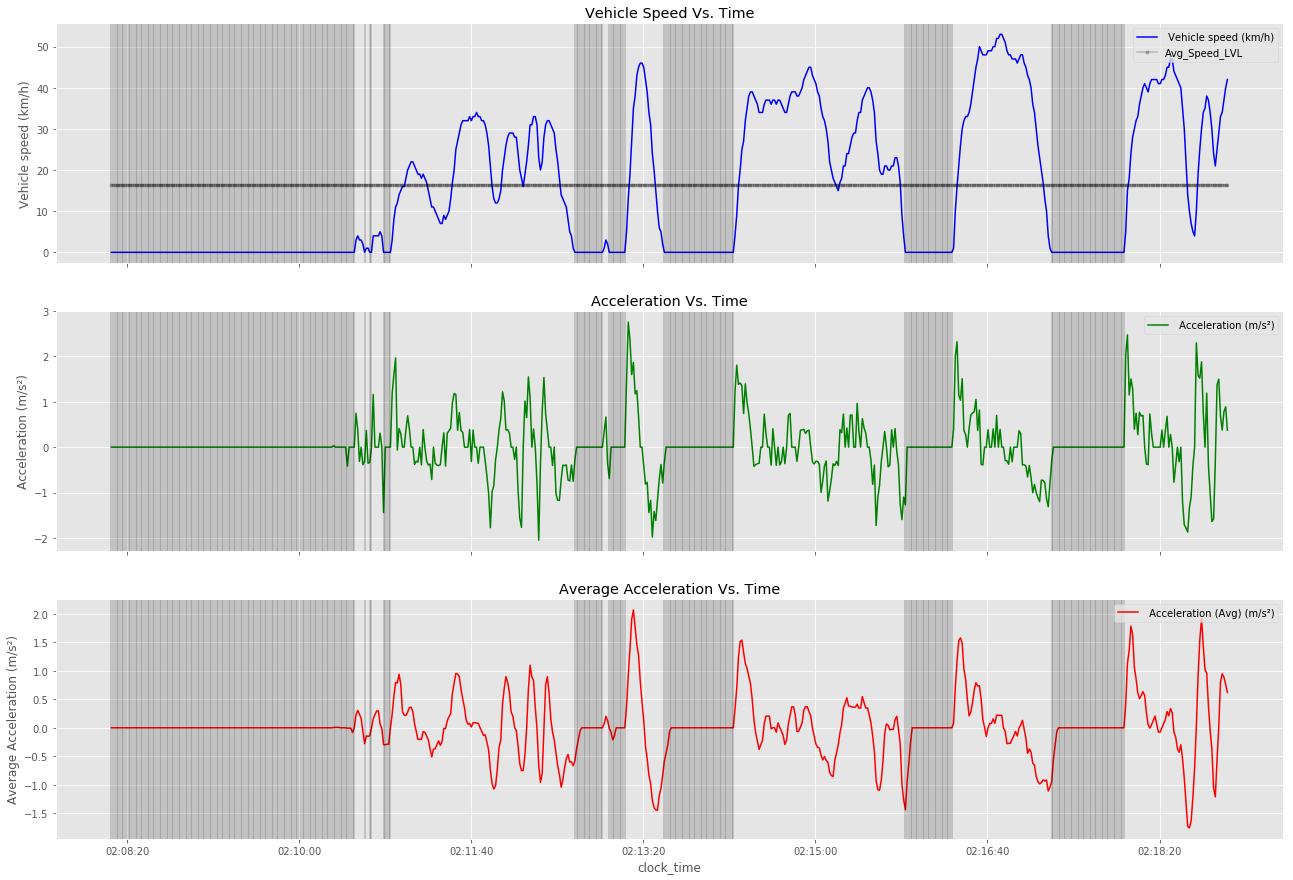

In [21]:
plot_dynamics(trip_1,avg_speed,avg_acc)

**Trip-1 Vehicle dynamics Analysis:**
    1. Initally there is idling -- may be because the driver is waiting for all the passengers
    2. The speed vs. time plot shows - the max speed reached is around 53 km/hr -- the driver is driving in the speed limits
    3. There is a sudden increase in the speed at 2:13:20 PM and then iding for about a minute -- this is a traffic signal -- general phenomenon
    4. Visually i think there are 4 traffic spots (black bands of lines) -- because the speed and acc are almost zero (excluding the initial idling time)
    5. band-1: 8:13:20, band-2: before 2:16:00, band-3: before 2:18:00
**Traffic spots will be verified using the T-DBSCAN algorithm**

<a id='EDA2'></a>

### 4.2 EDA for Trip-2

**Using File: CSVLog_20171127_140809_5.csv**

In [22]:
trip_2=preprocess_time(trip_2)

In [23]:
t_trip_2=trip_2[trip_2[' Latitude (deg)']!=0]
t_trip_2=t_trip_2[t_trip_2[' Longitude (deg)']!=0]
t_trip_2[[' Latitude (deg)',' Longitude (deg)', 'Time Stamp']].to_csv('TrajDBSCAN-master/trip_2.txt',index=False,header=False)

In [24]:
pickup_location,drop_location,p_d_df2,traffic_signals,avg_speed,avg_acc=descriptive_stats_for_trip(trip_2,'Trip-2')

------------------------Descriptive Stats for Trip-2------------------------


Trip Details------------------------------------------------------- 

Trip Date:  2017-11-27
Trip Day:  Monday
Pickup Time: ['02:52:00'] PM
Drop-off Time: ['03:01:03'] PM


Address Details------------------------------------------------------

Pick up Location: Latitude: 52.514720 deg, Longitude: 13.406340 deg
Pick up Address:  Fischerinsel, Mühlendamm, Spandauer Vorstadt, Mitte, Berlin, 10178, Deutschland


Drop off Location: Latitude: 52.508730 deg, Longitude: 13.391990 deg
Drop Off Address:  Rice And Roll, 76, Charlottenstraße, Spandauer Vorstadt, Mitte, Berlin, 10117, Deutschland


Total Trip Stats----------------------------------------------------

Trip Duration: 9.033333 mins
Total distance covered in the trip : 2.2328585421363734 (Kms)
Time of the day at which trip started:  nachm.
Time of the day at which trip ended:  nachm.


Vehicle Dynamics Stats---------------------------------------------------

**Trip -2 Stat Analysis:**
    1. From the descriptive stats: it can be observed the journey elapsed for 9 mins and the avg speed is 14.8 km/hr which 
    is normal when driving in a city like berlin
    2. The travel time is normal around 9 mins for 1.63 kms -- little bit high may be at this time there is traffic it is already 3PM, should be veririfed in the dynamics information

In [25]:
trip_2.head()

,Time,Latitude (deg),Longitude (deg),Vehicle speed (km/h),Acceleration (m/s²),Acceleration (Avg) (m/s²),Trip_time,Tag,Trip_date,Trip_day,Time Stamp
clock_time,,,,,,,,,,,
02:52:00.249600,11.27.2017 02:52:00.2496 nachm.,52.51472,13.40634,0,1.443290e-15,-2.241880e-01,2017-11-27 02:52:00.249600,nachm.,2017-11-27,Monday,02:52:00
02:52:01.249900,11.27.2017 02:52:01.2499 nachm.,52.51472,13.40634,0,1.443290e-15,-7.821067e-02,2017-11-27 02:52:01.249900,nachm.,2017-11-27,Monday,02:52:01
02:52:02.250200,11.27.2017 02:52:02.2502 nachm.,52.51472,13.40634,0,1.443290e-15,2.087219e-15,2017-11-27 02:52:02.250200,nachm.,2017-11-27,Monday,02:52:02
02:52:03.250400,11.27.2017 02:52:03.2504 nachm.,52.51472,13.40634,0,1.443290e-15,2.087219e-15,2017-11-27 02:52:03.250400,nachm.,2017-11-27,Monday,02:52:03
02:52:04.250700,11.27.2017 02:52:04.2507 nachm.,52.51472,13.40634,0,1.443290e-15,2.087219e-15,2017-11-27 02:52:04.250700,nachm.,2017-11-27,Monday,02:52:04


In [26]:
m,time_spent_traffic=plot_trip(trip_2,pickup_location,drop_location,traffic_signals)

In [27]:
# removed the red markers because they are not showing the idling locations very efficiently
m

**Trip-2 Map Analysis:**
    1. The blue marker - is the pick up and the black marker- is the drop off
    2. The red markers are not available because my approach is not able to find the traffic spots in this case 
    3. from the visual analysis of the map by zooming i found 3 traffic signals in the map
**Hover over the markers to get the address locations of the pickups and drop offs**

In [28]:
# the manual calculation for the idling time is failing here # i think the approach is not very efficient
print('Time Spent in Idling in traffic (approximately): %f mins'%(time_spent_traffic/60.0))

Time Spent in Idling in traffic (approximately): 0.000000 mins


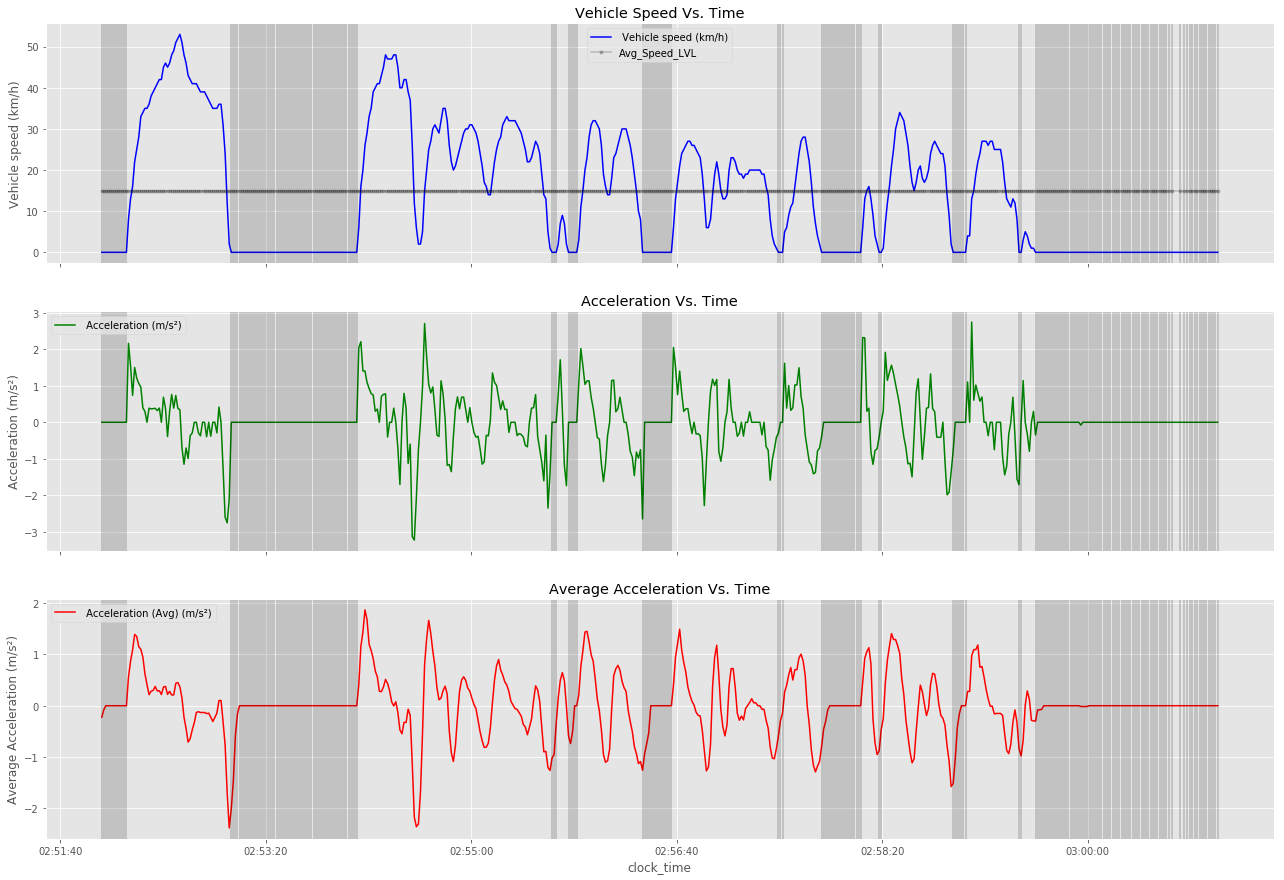

In [29]:
plot_dynamics(trip_2,avg_speed,avg_acc)

**Trip-2 Vehicle dynamics Analysis:**
    1. Initally there is a very small idling time
    2. The speed vs. time plot shows - the max speed reached is around 55 km/hr -- the driver is driving in the speed limits
    3. Visually i think there are 3 traffic spots -- from the map i could see that they might be the traffic signals
    4. 3 traffic spots are 3 bands of black lines excluding the idling time at the start and the end
    5. band-1: 2:53:20, band-2: before 2:56:40 and band-3: 2:58:20
    6. there is a lot of slow rolling and braking from - 2:55PM to 2:58 PM -- may be because of traffic
**Traffic spots will be verified using the T-DBSCAN algorithm**

<a id='EDA3'></a>

### 4.3 EDA for Trip-3

**Using File: CSVLog_20171127_121949_2.csv**

In [30]:
trip_3.head()

,Time,Latitude (deg),Longitude (deg),Vehicle speed (km/h),Acceleration (m/s²),Acceleration (Avg) (m/s²)
0,11.27.2017 12:29:51.7329 nachm.,52.51248,13.40804,38,-3.817540e-01,-0.231953
1,11.27.2017 12:29:52.7330 nachm.,52.51241,13.40814,38,1.665335e-16,-0.156218
2,11.27.2017 12:29:53.7337 nachm.,52.51234,13.40825,38,1.665335e-16,-0.156218
3,11.27.2017 12:29:54.7339 nachm.,52.51228,13.40837,39,3.856067e-01,0.000771
4,11.27.2017 12:29:55.7350 nachm.,52.51220,13.40847,39,1.665335e-16,0.077121


In [31]:
trip_3=preprocess_time(trip_3)

In [32]:
t_trip_3=trip_3[trip_3[' Latitude (deg)']!=0]
t_trip_3=t_trip_3[t_trip_3[' Longitude (deg)']!=0]
t_trip_3[[' Latitude (deg)',' Longitude (deg)', 'Time Stamp']].to_csv('TrajDBSCAN-master/trip_3.txt',index=False,header=False)

In [33]:
pickup_location,drop_location,p_d_df3,traffic_signals,avg_speed,avg_acc=descriptive_stats_for_trip(trip_3,'Trip-3')

------------------------Descriptive Stats for Trip-3------------------------


Trip Details------------------------------------------------------- 

Trip Date:  2017-11-27
Trip Day:  Monday
Pickup Time: ['12:29:51'] PM
Drop-off Time: ['12:39:56'] PM


Address Details------------------------------------------------------

Pick up Location: Latitude: 52.512480 deg, Longitude: 13.408040 deg
Pick up Address:  Haus Lademann, Wallstraße, Spandauer Vorstadt, Mitte, Berlin, 10179, Deutschland


Drop off Location: Latitude: 52.509650 deg, Longitude: 13.391060 deg
Drop Off Address:  68, Krausenstraße, Spandauer Vorstadt, Mitte, Berlin, 10117, Deutschland


Total Trip Stats----------------------------------------------------

Trip Duration: 10.083333 mins
Total distance covered in the trip : 2.9529598328259 (Kms)
Time of the day at which trip started:  nachm.
Time of the day at which trip ended:  nachm.


Vehicle Dynamics Stats----------------------------------------------------

Max speed attain

**Trip -3 Stat Analysis:**
    1. From the descriptive stats: it can be observed the journey elapsed for 10 mins and the avg speed is 17.5 km/hr which 
    is normal when driving in a city like berlin
    2. The travel time is normal around 10 mins for 2.95 kms -- less traffic generally at noon
    3. the driver took a very long route amost double the manhattan distance

In [34]:
m,time_spent_traffic=plot_trip(trip_3,pickup_location,drop_location)
# removed the red markers because they are not showing the idling locations very efficiently
m

**Trip-3 Map Analysis:**
    1. from the visual analysis of the map by zooming i found 3 traffic signals in the map and round about turn in the map
    2. The blue marker - is the pick up and the black marker- is the drop off
    3. The red markers are not available because my approach is not able to find the traffic spots in this case 
**Hover over the markers to get the address locations of the pickups and drop offs**

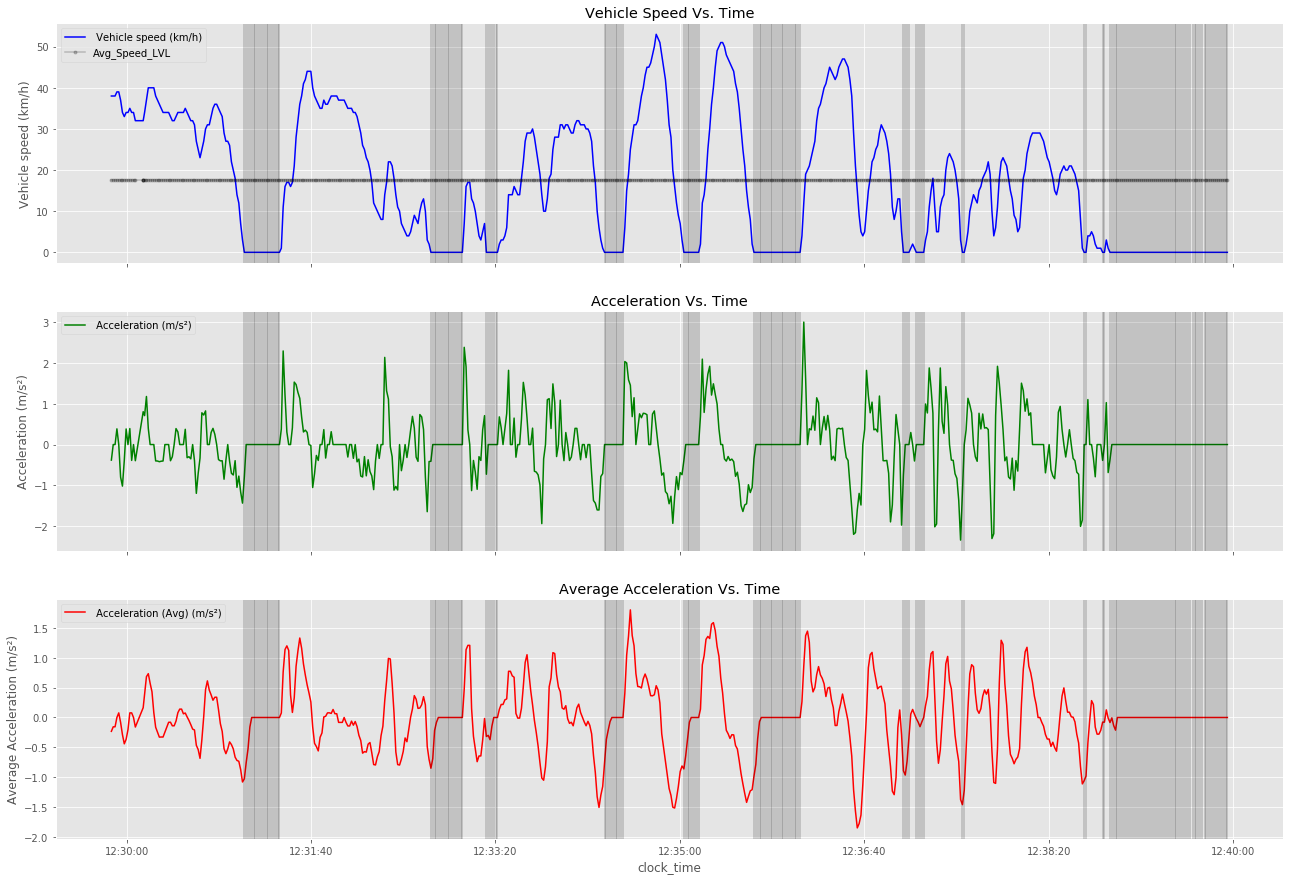

In [35]:
plot_dynamics(trip_3,avg_speed,avg_acc)

**Trip-3 Vehicle dynamics Analysis:**
    1. Initally there is no idling time
    2. The speed vs. time plot shows - the max speed reached is around 55 km/hr -- the driver is driving in the speed limits
    3. Visually i think there are 3 traffic spots -- from the map i could see that they might be the traffic signals
    4. 3 bands of black lines (excluding the idling time at the end) - show the traffic hot spots
    5. the bands are not very thick - most significant band is in between 12:35 and 12:36:40
    6. The round-about turn occured at 12:35:00 PM i think because of sudden increase and decrease of the speed while taking the turn
**Traffic spots will be verified using the T-DBSCAN algorithm**

<a id='EDA4'></a>
### 4.4 EDA for Trip-4
**Using File: CSVLog_20171128_080605.csv**

In [36]:
trip_4=preprocess_time(trip_4)

In [37]:
t_trip_4=trip_4[trip_4[' Latitude (deg)']!=0]
t_trip_4=t_trip_4[t_trip_4[' Longitude (deg)']!=0]
t_trip_4[[' Latitude (deg)',' Longitude (deg)', 'Time Stamp']].to_csv('TrajDBSCAN-master/trip_4.txt',index=False,header=False)

In [38]:
pickup_location,drop_location,p_d_df4,traffic_signals,avg_speed,avg_acc=descriptive_stats_for_trip(trip_4,'Trip-4')

------------------------Descriptive Stats for Trip-4------------------------


Trip Details------------------------------------------------------- 

Trip Date:  2017-11-28
Trip Day:  Tuesday
Pickup Time: ['08:06:07'] AM
Drop-off Time: ['08:16:55'] AM


Address Details------------------------------------------------------

Pick up Location: Latitude: 52.488910 deg, Longitude: 13.389740 deg
Pick up Address:  29, Nostitzstraße, Kreuzberg, Friedrichshain-Kreuzberg, Berlin, 10965, Deutschland


Drop off Location: Latitude: 52.508710 deg, Longitude: 13.391980 deg
Drop Off Address:  Rice And Roll, 76, Charlottenstraße, Spandauer Vorstadt, Mitte, Berlin, 10117, Deutschland


Total Trip Stats----------------------------------------------------

Trip Duration: 10.800000 mins
Total distance covered in the trip : 3.0954099887910114 (Kms)
Time of the day at which trip started:  vorm.
Time of the day at which trip ended:  vorm.


Vehicle Dynamics Stats------------------------------------------------

**Trip -4 Stat Analysis:**
    1. From the descriptive stats: it can be observed the journey elapsed for 10.8 mins and the avg speed is 17.19 km/hr which 
    is normal when driving in a city like berlin
    2. The travel time is normal around 10 mins for 3.09 kms -- less traffic generally at 8AM because offices start at 7AM
    3. the manhattan distance is almost the same as the distance covered in the trip

In [39]:
m,time_spent_traffic=plot_trip(trip_4,pickup_location,drop_location)
# removed the red markers because they are not showing the idling locations very efficiently
m

**Trip-4 Map Analysis:**
    1. from the visual analysis of the map by zooming i found 5 traffic signals in the map
    2. The blue marker - is the pick up and the black marker- is the drop off
    3. The red markers are not available because my approach is not able to find the traffic spots in this case 
**Hover over the markers to get the address locations of the pickups and drop offs**

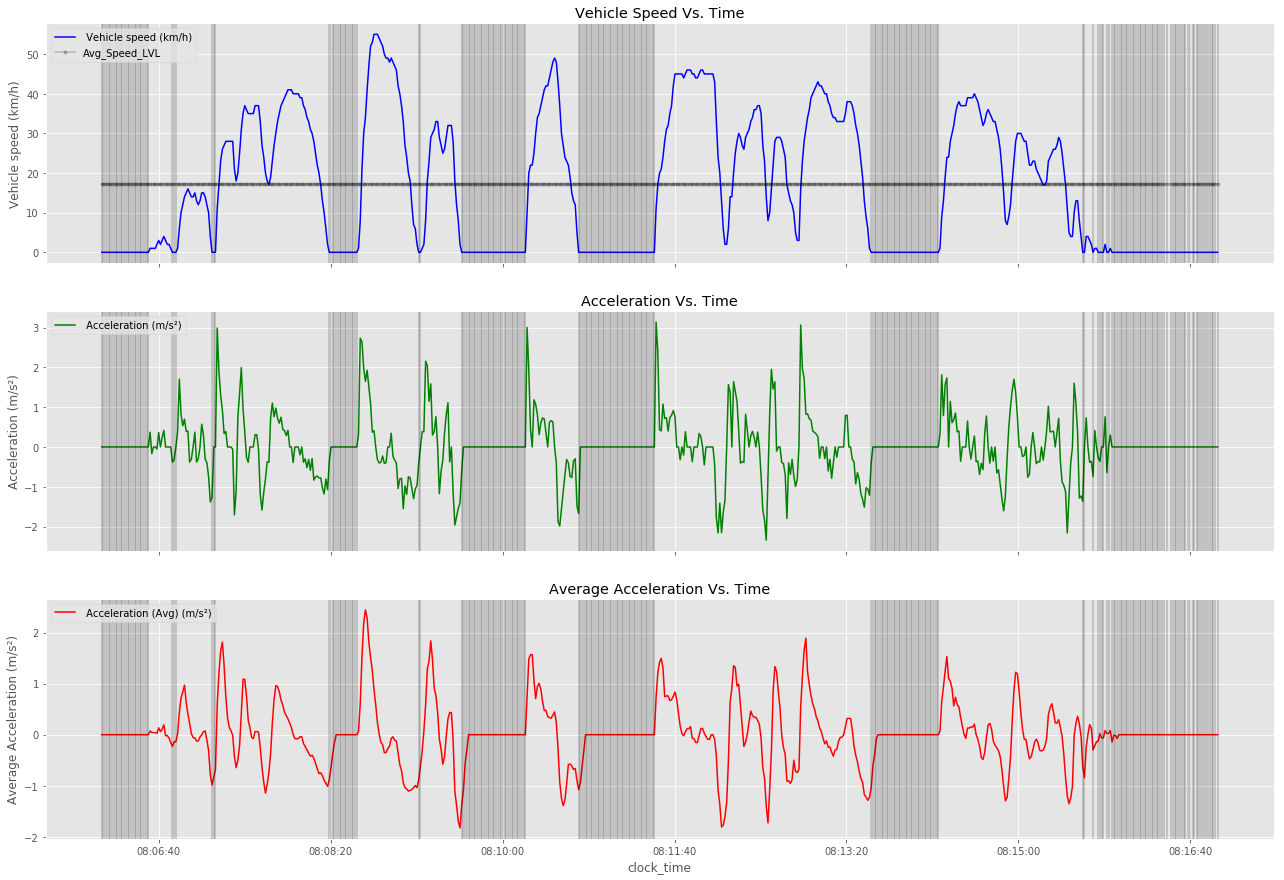

In [40]:
plot_dynamics(trip_4,avg_speed,avg_acc)

**Trip-4 Vehicle dynamics Analysis:**
    1. Initally there is little idling time
    2. The speed vs. time plot shows - the max speed reached is around 55 km/hr -- the driver is driving in the speed limits
    3. Visually i think there are 4 traffic spots -- from the map i could see 5 traffic signals -- may be at one particular signal the driver had arrived when the signal is green -- cannot decipher this information
    4. 4 bands of black lines can be observed -- traffic hot spots (excluding the initial and final idling time)
    5. band-1 : 08:08:20, band-2: centerd at 08:10:00, band-3: before 8:11:40, band-4: after 8:13:20
   
**Traffic spots will be verified using the T-DBSCAN algorithm**

<a id='EDA5'></a>

### 4.5 EDA for Trip-5
**Using File: CSVLog_20171128_131456_4.csv**

In [41]:
trip_5=preprocess_time(trip_5)

In [42]:
t_trip_5=trip_5[trip_5[' Latitude (deg)']!=0]
t_trip_5=t_trip_5[t_trip_5[' Longitude (deg)']!=0]
t_trip_5[[' Latitude (deg)',' Longitude (deg)', 'Time Stamp']].to_csv('TrajDBSCAN-master/trip_5.txt',index=False,header=False)

In [43]:
pickup_location,drop_location,p_d_df5,traffic_signals,avg_speed,avg_acc=descriptive_stats_for_trip(trip_5,'Trip-5')

------------------------Descriptive Stats for Trip-5------------------------


Trip Details------------------------------------------------------- 

Trip Date:  2017-11-28
Trip Day:  Tuesday
Pickup Time: ['01:48:00'] PM
Drop-off Time: ['01:58:05'] PM


Address Details------------------------------------------------------

Pick up Location: Latitude: 52.483130 deg, Longitude: 13.439130 deg
Pick up Address:  1, Laubestraße, Donaukiez, Neukölln, Berlin, 12045, Deutschland


Drop off Location: Latitude: 52.493140 deg, Longitude: 13.391160 deg
Drop Off Address:  Lenau-Grundschule, Nostitzstraße, Kreuzberg, Friedrichshain-Kreuzberg, Berlin, 10961, Deutschland


Total Trip Stats----------------------------------------------------

Trip Duration: 10.083333 mins
Total distance covered in the trip : 3.8266248416152036 (Kms)
Time of the day at which trip started:  nachm.
Time of the day at which trip ended:  nachm.


Vehicle Dynamics Stats----------------------------------------------------

Max 

**Trip -5 Stat Analysis:**
    1. From the descriptive stats: it can be observed the journey elapsed for 10 mins and the avg speed is 22.8 km/hr which 
    is OK when driving in a city like berlin
    2. The travel time is normal around 10 mins for 3.8 kms -- less because there might be no traffic from 1:48 PM to 2:00PM

In [44]:
m,time_spent_traffic=plot_trip(trip_5,pickup_location,drop_location)
# removed the red markers because they are not showing the idling locations very efficiently
m

**Trip-5 Map Analysis:**
    1. from the visual analysis of the map by zooming i found 11 traffic signals in the map
    2. The blue marker - is the pick up and the black marker- is the drop off
    3. The red markers are not available because my approach is not able to find the traffic spots in this case 
**Hover over the markers to get the address locations of the pickups and drop offs**

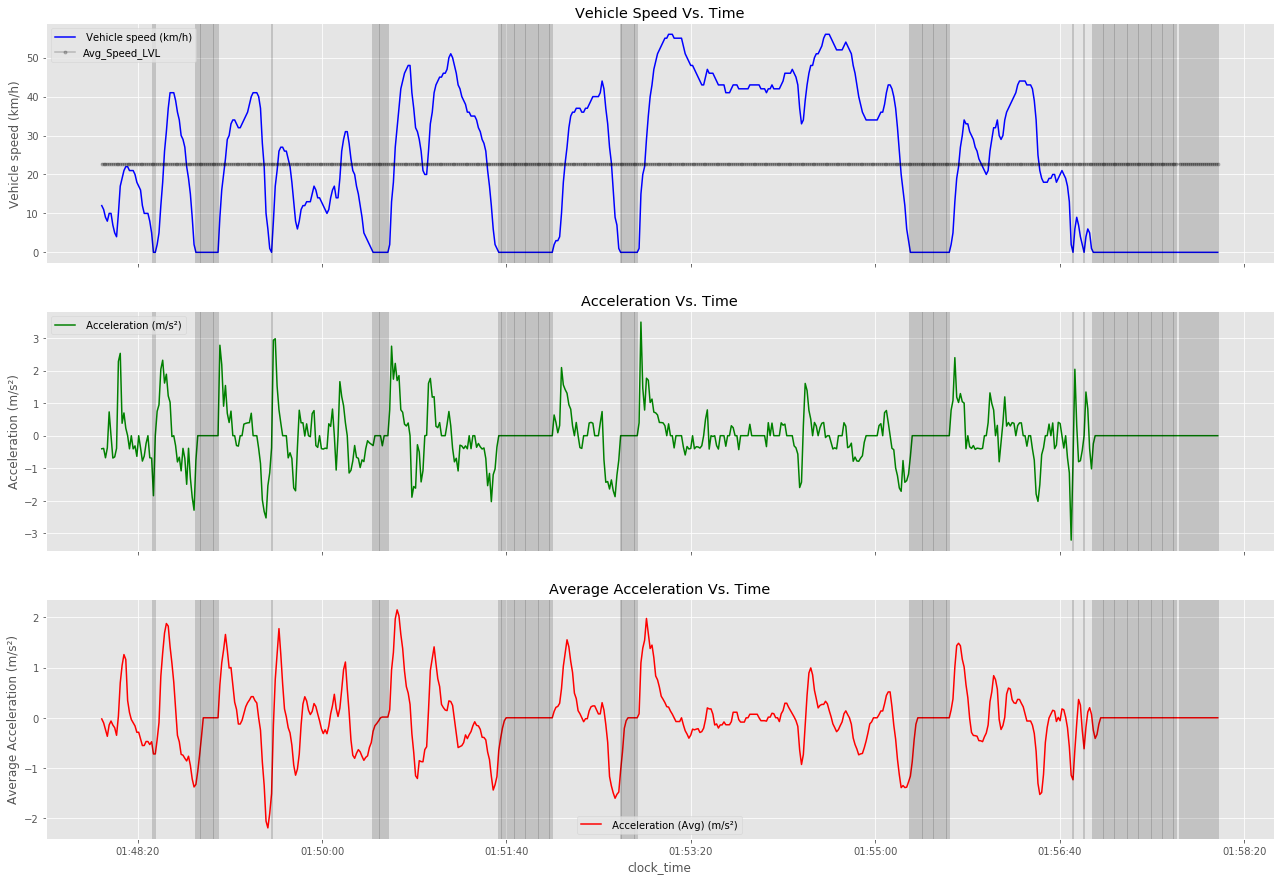

In [45]:
plot_dynamics(trip_5,avg_speed,avg_acc)

**Trip-5 Vehicle dynamics Analysis:**
    1. Initally there is little idling time
    2. The speed vs. time plot shows - the max speed reached is around 58 km/hr -- the driver is driving in the speed limits
    3. Visually i think there are 5 traffic spots -- from the map i could see 11 traffic signals -- since the traffic is less at this point of time may be there is lower probability to encounter a red-signal
    4. 2 significant black bands of lines -- traffic hotspots (at 1:51:40 and at 1:55:00) 
   
**Traffic spots will be verified using the T-DBSCAN algorithm**

<a id='EDA6'></a>

### 4.6 EDA for Trip-6
**Using File: CSVLog_20171129_083743.csv**

In [46]:
trip_6=preprocess_time(trip_6)

In [47]:
t_trip_6=trip_6[trip_6[' Latitude (deg)']!=0]
t_trip_6=t_trip_6[t_trip_6[' Longitude (deg)']!=0]
t_trip_6[[' Latitude (deg)',' Longitude (deg)', 'Time Stamp']].to_csv('TrajDBSCAN-master/trip_6.txt',index=False,header=False)

In [48]:
pickup_location,drop_location,p_d_df6,traffic_signals,avg_speed,avg_acc=descriptive_stats_for_trip(trip_6,'Trip-6')

------------------------Descriptive Stats for Trip-6------------------------


Trip Details------------------------------------------------------- 

Trip Date:  2017-11-29
Trip Day:  Wednesday
Pickup Time: ['08:37:44'] AM
Drop-off Time: ['08:48:28'] AM


Address Details------------------------------------------------------

Pick up Location: Latitude: 52.493030 deg, Longitude: 13.396920 deg
Pick up Address:  11, Mittenwalder Straße, Kreuzberg, Friedrichshain-Kreuzberg, Berlin, 10961, Deutschland


Drop off Location: Latitude: 52.509610 deg, Longitude: 13.392810 deg
Drop Off Address:  BMUB, Krausenstraße, Spandauer Vorstadt, Mitte, Berlin, 10117, Deutschland


Total Trip Stats----------------------------------------------------

Trip Duration: 10.716667 mins
Total distance covered in the trip : 2.504825817286733 (Kms)
Time of the day at which trip started:  vorm.
Time of the day at which trip ended:  vorm.


Vehicle Dynamics Stats----------------------------------------------------

Max

**Trip-6 Stat Analysis:**
    1. From the descriptive stats: it can be observed the journey elapsed for 10.7 mins and the avg speed is 14.02 km/hr which 
    is normal when driving in a city like berlin
    2. The travel time is normal around 10 mins for 2.5 kms -- may be there is traffic in this region around 8:37 AM
    3. the manhattan distance is almost the same as the distance covered in the trip

In [49]:
m,time_spent_traffic=plot_trip(trip_6,pickup_location,drop_location)
# removed the red markers because they are not showing the idling locations very efficiently
m

**Trip-6 Map Analysis:**
    1. from the visual analysis of the map by zooming i found 4 traffic signals in the map
    2. The blue marker - is the pick up and the black marker- is the drop off
    3. The red markers are not available because my approach is not able to find the traffic spots in this case 
**Hover over the markers to get the address locations of the pickups and drop offs**

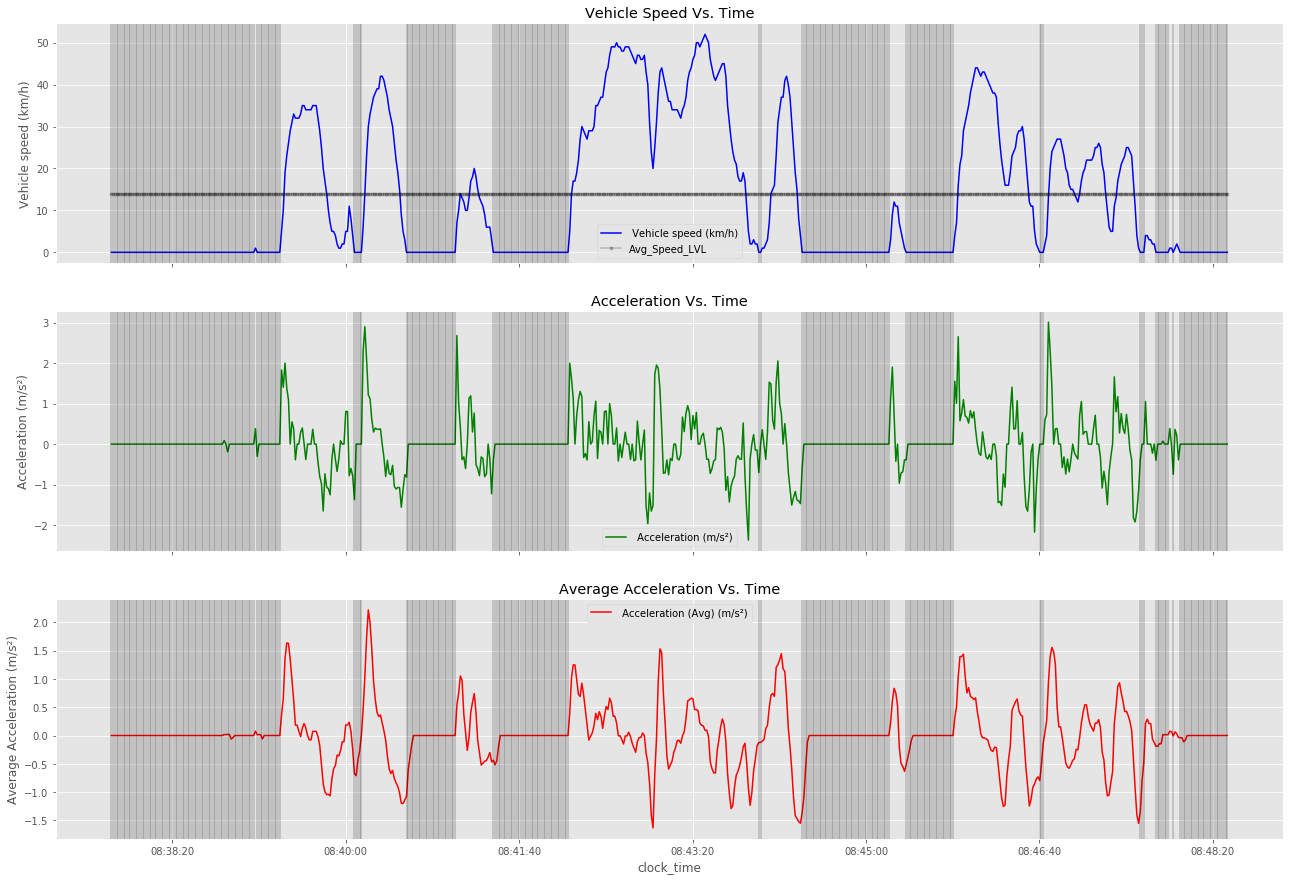

In [50]:
plot_dynamics(trip_6,avg_speed,avg_acc)

**Trip-6 Vehicle dynamics Analysis:**
    1. Initally there is little idling time
    2. The speed vs. time plot shows - the max speed reached is around 50 km/hr -- the driver is driving in the speed limits
    3. Visually i think there are 4 traffic spots -- from the map i could see 4 traffic signals--matched
    4. 4 thick bands -corresponding the traffic hotspots (excluding the initial and final idling time)
    5. band-1: btn 8:40 and 8:41:40, band-2: centered at 8:41:40, band 3 and 4: centerd at 8:45:00
   
**Traffic spots will be verified using the T-DBSCAN algorithm**

<a id='clustering'></a>

## 5. Clustering with 3 different algorithms

In [51]:
pick_drop_df=pd.concat([p_d_df1, p_d_df2,p_d_df3,p_d_df4,p_d_df5,p_d_df6])

In [52]:
pick_drop_df.reset_index(inplace=True)
pick_drop_df.drop("index",axis=1,inplace=True)
pick_drop_df.head(10)

,Trip Number,Trip Date,Pickup Time,Drop off Time,Pickup Latitude,Pickup Longitude,Drop off Latitude,Drop off Longitude,Manhattan_distance
0,Trip-1,2017-11-27,2017-11-27 02:08:34.811500,2017-11-27 02:18:59.442500,52.50856,13.39184,52.51352,13.42443,2.758018
1,Trip-2,2017-11-27,2017-11-27 02:52:00.249600,2017-11-27 03:01:03.219100,52.51472,13.40634,52.50873,13.39199,1.637615
2,Trip-3,2017-11-27,2017-11-27 12:29:51.732900,2017-11-27 12:39:56.950100,52.51248,13.40804,52.50965,13.39106,1.464211
3,Trip-4,2017-11-28,2017-11-28 08:06:07.896500,2017-11-28 08:16:55.905300,52.48891,13.38974,52.50871,13.39198,2.354065
4,Trip-5,2017-11-28,2017-11-28 01:48:00.570600,2017-11-28 01:58:05.693100,52.48313,13.43913,52.49314,13.39116,4.362822
5,Trip-6,2017-11-29,2017-11-29 08:37:44.834600,2017-11-29 08:48:28.426100,52.49303,13.39692,52.50961,13.39281,2.122533


<a id='clustering1'></a>

### 5.1 K-Means Clutering for Pick-up Location

In [53]:
# clustering the pick-up locations
pick_drop_df_cl, k_means = cluster_assignment(pick_drop_df,2)
centroid_pickups = pd.DataFrame(k_means.cluster_centers_, columns = ['centroid_pick_lat', 'centroid_pick_long'])
centroid_dropoff = pd.DataFrame(k_means.cluster_centers_, columns = ['centroid_drop_lat', 'centroid_drop_long'])

# obtaining the cluster assignments for the pick up and drop-offs
centroid_pickups['label_pick'] = centroid_pickups.index
centroid_dropoff['label_drop'] = centroid_dropoff.index

# merging cluster data to the dataframe
pick_drop_df_cl = pd.merge(pick_drop_df_cl, centroid_pickups, how='left', on=['label_pick'])
pick_drop_df_cl = pd.merge(pick_drop_df_cl, centroid_dropoff, how='left', on=['label_drop'])

In [54]:
pick_drop_df_cl.head()

,Trip Number,Trip Date,Pickup Time,Drop off Time,Pickup Latitude,Pickup Longitude,Drop off Latitude,Drop off Longitude,Manhattan_distance,label_pick,label_drop,centroid_pick_lat,centroid_pick_long,centroid_drop_lat,centroid_drop_long
0,Trip-1,2017-11-27,2017-11-27 02:08:34.811500,2017-11-27 02:18:59.442500,52.50856,13.39184,52.51352,13.42443,2.758018,0,0,52.50354,13.398576,52.50354,13.398576
1,Trip-2,2017-11-27,2017-11-27 02:52:00.249600,2017-11-27 03:01:03.219100,52.51472,13.40634,52.50873,13.39199,1.637615,0,0,52.50354,13.398576,52.50354,13.398576
2,Trip-3,2017-11-27,2017-11-27 12:29:51.732900,2017-11-27 12:39:56.950100,52.51248,13.40804,52.50965,13.39106,1.464211,0,0,52.50354,13.398576,52.50354,13.398576
3,Trip-4,2017-11-28,2017-11-28 08:06:07.896500,2017-11-28 08:16:55.905300,52.48891,13.38974,52.50871,13.39198,2.354065,0,0,52.50354,13.398576,52.50354,13.398576
4,Trip-5,2017-11-28,2017-11-28 01:48:00.570600,2017-11-28 01:58:05.693100,52.48313,13.43913,52.49314,13.39116,4.362822,1,0,52.48313,13.439130,52.50354,13.398576


In [55]:
# function to cluster only the pickup locations -- can be changed to the drop-off locations as well
def clusters_map(clus_data, full_data, tile = 'OpenStreetMap', sig = 0, zoom = 12, circle = 0, radius_ = 20):
    map_1 = folium.Map(location=[52.5200, 13.4050], zoom_start=zoom,tiles= tile)
    sig_cluster = full_data['label_pick'].tolist()
    trips=full_data['Trip Number'].tolist()
    # adding all the pick up locations
    for i in range(len(trips)):
        t_pick_lat = full_data.loc[full_data.index ==i]['Pickup Latitude'].values[0]
        t_pick_long = full_data.loc[full_data.index ==i]['Pickup Longitude'].values[0]
        folium.Marker([t_pick_lat, t_pick_long],popup=('Pickup Location for Trip - '+str(i+1)),icon=folium.Icon(color='blue')).add_to(map_1)
     # extracting the cluster centroids
    for i in sig_cluster:
        pick_long = clus_data.loc[clus_data.index ==i]['centroid_pick_long'].values[0]
        pick_lat = clus_data.loc[clus_data.index ==i]['centroid_pick_lat'].values[0]
        if circle == 1:
            folium.CircleMarker(location=[pick_lat, pick_long], radius=radius_,
                    color='#F08080',
                    fill_color='#3186cc').add_to(map_1)
        folium.Marker([pick_lat, pick_long],icon=folium.Icon(color='green'),popup=('Pickup Centroid for Cluster - '+str(i))).add_to(map_1)
    
    
    return map_1

In [56]:
# cluster centroids for the pickups
k_means.cluster_centers_

array([[52.50354 , 13.398576],
       [52.48313 , 13.43913 ]])

In [57]:
clus_map = clusters_map(centroid_pickups, pick_drop_df_cl, sig =0, zoom =12, circle =1)

In [58]:
clus_map

**Visual Analysis of the pick-up Clusters:**
    1. There are two clusters - Cluster - 0 -- is almost capturing all the trip pickups (Trip nrs. 1,2,3,4,6)
    2. The Cluster-1 -- is only for 1 trip -- it is for trip nr.-5 because it is bit farther away from the other trip pickups
    3. Green Marker - Cluster Centroids
    4. Blue Marker - Trips

**Silhouette score is used to determine the K value in the K means algorithm and here it is 2 because all the other K have low scores**

In [59]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(pick_drop_df[['Pickup Latitude','Pickup Longitude']].values, pick_drop_df['label_pick'])
print("For n_clusters =", 2,"The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.501419745555458


In [60]:
#silhouette_avg = silhouette_score(pick_drop_df[['Pickup Latitude','Pickup Longitude']].values, pick_drop_df['label_pick'])
#print("For n_clusters =", 3,"The average silhouette_score is :", silhouette_avg)

In [61]:
#from sklearn.metrics import silhouette_score
#silhouette_avg = silhouette_score(pick_drop_df[['Pickup Latitude','Pickup Longitude']].values, pick_drop_df['label_pick'])
#print("For n_clusters =", 4,"The average silhouette_score is :", silhouette_avg)

In [62]:
#from sklearn.metrics import silhouette_score
#silhouette_avg = silhouette_score(pick_drop_df[['Pickup Latitude','Pickup Longitude']].values, pick_drop_df['label_pick'])
#print("For n_clusters =", 5,"The average silhouette_score is :", silhouette_avg)

<a id='clustering2'></a>

### 5.2 Clustering using DBSCAN for pick-ups and drop-locations

In [63]:
from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPoint
from geopy.distance import great_circle

This part of the code is taken from: https://www.kaggle.com/tuomastik/black-yellow-nyc-taxi-trip-data-exploration

In [64]:
KMS_PER_RADIAN = 6371.0088
ROUND_DECIMALS = 5

def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

map_osm = folium.Map(location=[52.5200, 13.4050], zoom_start=11, tiles='OpenStreetMap')

for var_descr, var_names, color, icon in zip(
        ["Pickup location", "Drop-off location"],
        [["Pickup Latitude", "Pickup Longitude"], ["Drop off Latitude", "Drop off Longitude"]],
        ["orange", "black"], ["arrow-up", "arrow-down"]):
    print("Rounding to %i decimal places and removing duplicates from %s data." % (
        ROUND_DECIMALS, var_descr.lower()))
    train_copy = pick_drop_df.copy()  # Let's leave the original untouched
    train_copy[var_names] = train_copy[var_names].round(ROUND_DECIMALS)
    coords = train_copy[var_names].drop_duplicates()
    print("Kept %.1f %% of the %s data." % (100 * coords.shape[0] / train_copy.shape[0],
                                            var_descr.lower()))
    db = DBSCAN(eps=0.4 / KMS_PER_RADIAN, min_samples=0.08*coords.shape[0], algorithm='ball_tree',
                metric='haversine', n_jobs=-1).fit(np.radians(coords.as_matrix()))
    # There is one cluster for noisy examples, labeled as -1 
    n_clusters = (len(set(db.labels_)) - 1 if -1 in db.labels_ else
                  len(set(db.labels_)))
    print('Found {} {} clusters.\n-----------------------------------'.format(
        n_clusters, var_descr.lower()))
    clusters_coords = [coords[db.labels_ == n] for n in range(n_clusters)]
    # Find the point in each cluster that is closest to its centroid
    centermost_points = [get_centermost_point(list(c.itertuples(index=False))) for
                         c in clusters_coords]
    clusters_with_all_orig_data = [pd.merge(train_copy, c, how='inner', on=var_names)
                                   for c in clusters_coords]
    for i, ((lat, lng), c) in enumerate(zip(centermost_points, clusters_with_all_orig_data)):
        
        [folium.Marker([lat, lng], icon=folium.Icon(color=color, icon=icon)).add_to(map_osm)]
map_osm

Rounding to 5 decimal places and removing duplicates from pickup location data.
Kept 100.0 % of the pickup location data.
Found 5 pickup location clusters.
-----------------------------------
Rounding to 5 decimal places and removing duplicates from drop-off location data.
Kept 100.0 % of the drop-off location data.
Found 3 drop-off location clusters.
-----------------------------------


**A bit of new information is gained from DBSCAN -- it is showing actually 5 pickup clusters (it is showing the pick up locatios directly as clusters -- seems not correct) and 3 dropoff clusters (almost all the drop off locations)**

**I think this will work when some more trips are there...only 6 trips are available here so not much to gain from this method**

<a id='clustering3'></a>

### 5.3 Traffic Hotspots Clusteing using Trip-Trajectories with Time Series data

** I have read the following paper about clustering in a trajectory because of halting/stopping in a trip: http://dx.doi.org/10.3991/ijoe.v10i6.3881**

**Main Idea:** How can the time stamped GPS trajectory be used? The best way i could find is to use the Trajectory - DBSCAN algorithm which basically clusters the halting location of a vehicle which has time stamped data. these should also include mid dropoffs in a trip when the driver visited a place in between the trip. But in this case there are not long user halts except the traffic halts. Therefore i thought this could be used to cluster for traffic hot spots in the data. If more data is there then i think we can separate the traffic halts and personal halts. All the procedures to do this are explained in the paper link above

Generally people when driving the vehicle get anxious when the traffic signal is more than 1.5 mins, but here i used 30 seconds to check if the algorithm T-DBSCAN is working or not.

The T-DBSCAN algorithm is A Spatiotemporal Density Clustering for GPS Trajectory Segmentation: which is available at this
link: https://github.com/devil1993/TrajDBSCAN

**I would have self-coded it myself but because of the time-constraint i used the one avaialble in the GitHub**

This algorithm reqiures the following data:
-  Latitude , Longitude and Time Stamp in this order and in comma-separated file
-  The algorithm takes in two parameters - eps and mintime
-  I used the default eps value and changed the mintime - for waiting is 30 secs
    
The instructions for executing the T_DBSCAN algorithm is provided in the README.md located in folder: **TrajDBSCAN-master**

**I think when this algorithm is properly extended over an entire database of trips in the Berlin city, i think the traffic hot spots in a day can be clustered**

<a id='tclus1'></a>
### 5.3.1 Trajectory clustering for trip-1

In [119]:
# extracting traffic hot spot information stored in file generated by the Trajectory DBSCAN algorithm
traffic_clusters=pd.read_csv('./TrajDBSCAN-master/clusters_trip_1.txt',header=-1)

In [120]:
traffic_clusters.drop(3,axis=1,inplace=True)

In [121]:
traffic_clusters.head()

,0,1,2
0,52.508541,13.391924,2.668342e-05
1,52.510849,13.397942,4.844641e-06
2,52.510944,13.400499,3.268835e-05
3,52.515550,13.417470,1.292428e-07


In [122]:
m,hotspots=plot_trip_traffic(trip_1,pickup_location,drop_location,traffic_clusters)
m

**Traffic Hotspot Clustering for Trip-1:**
For trip-1 there are **3** traffic hotspots which are greater than 30seconds - this means the driver has waited at these markers pointed in red for more than 30 seconds. This could be because of the presence of red signal or traffic blockage. 

**Hovering over the red markers will give a time stamp when the driver entered a traffic hotspot and using the vehicle dynamic information i have plotted the hotspot locations with blue arrows below** 

![hotspot-png](trip_1_traffic_hotspots.png)

<a id='tclus2'></a>
### 5.3.2 Trajectory clustering for trip-2

In [123]:
# extracting traffic hot spot information stored in file generated by the Trajectory DBSCAN algorithm
traffic_clusters=pd.read_csv('./TrajDBSCAN-master/clusters_trip_2.txt',header=-1)

In [124]:
traffic_clusters.drop(3,axis=1,inplace=True)

In [125]:
traffic_clusters.head()

,0,1,2
0,52.511397,13.401411,0.000028
1,52.508680,13.391975,0.000021


In [126]:
m,hotspots=plot_trip_traffic(trip_2,pickup_location,drop_location,traffic_clusters)

In [127]:
m

**Traffic Hotspot Clustering for Trip-2:**
For trip-1 there are **1** traffic hotspots which are greater than 30seconds - this means the driver has waited at these markers pointed in red for more than 30 seconds. This could be because of the presence of red signal or traffic blockage. 

**Hovering over the red markers will give a time stamp when the driver entered a traffic hotspot. This location can be counter-verified with vehicle dynamics information and does point to one of the band- center at 2:53:00 in the vehicle dynamics section for trip-2** 

<a id='tclus3'></a>
### 5.3.3 Trajectory clustering for trip-3

In [128]:
# extracting traffic hot spot information stored in file generated by the Trajectory DBSCAN algorithm
traffic_clusters=pd.read_csv('./TrajDBSCAN-master/clusters_trip_3.txt',header=-1)

In [129]:
traffic_clusters.drop(3,axis=1,inplace=True)

In [130]:
traffic_clusters.head()

,0,1,2
0,52.503838,13.410673,0.000072
1,52.509651,13.391049,0.000013


In [131]:
m,_=plot_trip_traffic(trip_3,pickup_location,drop_location,traffic_clusters)
m

**Traffic Hotspot Clustering for Trip-3:**
For trip-1 there are **0** traffic hotspots which are greater than 30seconds - this means the driver has waited at these markers pointed in red for less than 30 seconds.Free flowing traffic or got luck at the traffic signals

**There are no red markers in this trip. Hence the traffic hotspots are for less than 30 seconds** 

<a id='tclus4'></a>
### 5.3.4 Trajectory clustering for trip-4

In [132]:
# extracting traffic hot spot information stored in file generated by the Trajectory DBSCAN algorithm
traffic_clusters=pd.read_csv('./TrajDBSCAN-master/clusters_trip_4.txt',header=-1)

In [133]:
traffic_clusters.drop(3,axis=1,inplace=True)

In [134]:
traffic_clusters.head()

,0,1,2
0,52.489016,13.389889,0.000050
1,52.496745,13.389459,0.000015
2,52.498901,13.388801,0.000002
3,52.506343,13.390337,0.000005
4,52.508684,13.391987,0.000015


In [135]:
m,hotspots=plot_trip_traffic(trip_4,pickup_location,drop_location,traffic_clusters)
m

**Traffic Hotspot Clustering for Trip-4:**
For trip-1 there are **4** traffic hotspots which are greater than 30seconds - this means the driver has waited at these markers pointed in red for more than 30 seconds.

**Hovering over the red markers will give a time stamp when the driver entered a traffic hotspot. These locations can be counter-verified with vehicle dynamics information and i have verified and the hotspots - are for band at 8:10, for band before 8:11:30, for band at 8:14 and the last band** 

![hotspot](trip_4_traffic_hotspots.png)

<a id='tclus5'></a>
### 5.3.5 Trajectory clustering for trip-5

In [136]:
# extracting traffic hot spot information stored in file generated by the Trajectory DBSCAN algorithm
traffic_clusters=pd.read_csv('./TrajDBSCAN-master/clusters_trip_5.txt',header=-1)

In [137]:
traffic_clusters.drop(3,axis=1,inplace=True)

In [138]:
traffic_clusters.head()

,0,1,2
0,52.486043,13.424942,0.000008
1,52.493164,13.391164,0.000011


In [139]:
m,hotspots=plot_trip_traffic(trip_5,pickup_location,drop_location,traffic_clusters)
m

**Traffic Hotspot Clustering for Trip-5:**
For trip-1 there are **1** traffic hotspots which are greater than 30seconds - this means the driver has waited at these markers pointed in red for more than 30 seconds.

**Hovering over the red markers will give a time stamp when the driver entered a traffic hotspot. These locations can be counter-verified with vehicle dynamics information** 

<a id='tclus6'></a>
### 5.3.6 Trajectory clustering for trip-6

In [140]:
# extracting traffic hot spot information stored in file generated by the Trajectory DBSCAN algorithm
traffic_clusters=pd.read_csv('./TrajDBSCAN-master/clusters_trip_6.txt',header=-1)

In [141]:
traffic_clusters.drop(3,axis=1,inplace=True)

In [142]:
traffic_clusters.head()

,0,1,2
0,52.493166,13.396877,0.000022
1,52.496813,13.395346,0.000006
2,52.506991,13.398198,0.000066
3,52.509614,13.392880,0.000026


In [143]:
m,hotspots=plot_trip_traffic(trip_6,pickup_location,drop_location,traffic_clusters)
m

**Traffic Hotspot Clustering for Trip-6:**
For trip-1 there are **2** traffic hotspots which are greater than 30seconds - this means the driver has waited at these markers pointed in red for more than 30 seconds.

**Hovering over the red markers will give a time stamp when the driver entered a traffic hotspot. These locations can be counter-verified with vehicle dynamics information as shown below** 

![trip-6](trip_6_traffic_hotspots.png)

<a id='conclusion'></a>

## 6. Conclusion and Outlook

1. Descriptive statistics for all the trips are provided in section 4.
2. Vehicle dynamics information is plotted alogwith the idling positions
3. All the trajectories are plotted on the maps
4. 2 clustering algorithms K-Means and DBSCAN are used for clustering the pickups and drop offs
5. I wanted to use supervised ML algorithms but could not get an idea - because of small dataset size - donot know how to use vehicle dynamics information, may be something could be done in the lines of longitudnal vehicle dynamics if angular accelerations and steering angle is provided but it is not present in the data
6. I have researched on google and found out if there is timestamped GPS data then it can be used for clustering for halts taken by the driver, so here as the trips are small and from the EDA i knew that the halts are for traffic signals or normal rolling traffic. Hence i took advantage of this idea and used the T-DBSCAN algorithm to provide more insight into the data
7. all the traffic hotspots are obtained by executing the Trajectory-DBSCAN algorithm whic gave the cluster centroids
8. Using the traffic hotspot cluster centroids i plotted the red markers on the map and they can be verified using the vehicle dynamic informtation by looking at the idling bands -- gen you stop at the traffic signal


**Outlook**

-  Further improvements can be made in the direction of using vehicle dynamic information and categorizing the driver driving behavior but for this some amount of steering and angular accelerations are needed
-  Improvements can be done in the Traj-DBSCAN algorithm inorder to properly capture the traffic hotspots, i just used the open source code available in GitHub, i did not have enough time to develop it completely from scratch. I know this is not a good idea but for just checking if the algo is worthwhile using then open source codes should be enough
- I think creating realtime animations using the trajectories + dynamics will help a lot in visaulizing the driving patterns
- If the T-DBSCAN algorithm is extended prooperly then can be used to find out the busiest roads, busiest traffic signals in a city-- will help in surging the rental prices!!!

I can think of only these. Please give some comments about the notebook